# Description

This notebook trains a model to predict one of 10 classes related to driver distraction detection, with data from [Kaggle](https://www.kaggle.com/jerrinv/driver-distraction/data). These classes are 

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger.

Since these classes relate to beverages, cell phones, radios, etc., object detection might prove valuable in this instance. Additionally,
since the position of a driver behind the wheel is indicative of whether or not the person is paying attention to the road, human pose estimation techniques might be another viable option.

Consequently, this notebook applies transfer learning from a state-of-the-art human pose detection solution [openpose](https://arxiv.org/abs/1812.08008), which is transfer learned from the famous VGG19 block, an object detection solution. Setting up this architecture was quite difficult, since the openpose has multiple branches that merge and then diverge again, and it also takes three inputs, of which two were discarded, since they relate specifically to human pose.

The model trains for 15 epochs, although we probably could have let it train for about 8 epochs, since the loss and accuracy have changed very little since then.

An investigation into the data revealed that the images are generally from more or less the same vantage point, have the same size, and that there are an equal number of examples for each class, which means that class imbalance is no problem. This data set has clearly been curated and cleaned, which is typically not the case in real life. As a result, we could get away without too much data augmentation or upsampling, and were able to achieve a 99.5% accuracy on the validation set, and a 99.3% accuracy on the test set.



In [16]:
# Mount drive and clone the openpose project
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
!git clone https://github.com/cchamber/openpose_keras.git
os.mkdir('openpose_keras/model/keras')
!wget --directory-prefix openpose_keras/model/keras https://www.dropbox.com/s/llpxd14is7gyj0z/model.h5 

Mounted at /content/gdrive


In [0]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Flatten, Reshape, Concatenate, Input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline 

from openpose_keras.model import get_training_model, get_testing_model


In [0]:
# constants
FILE_NAME = 'combine_vgg_and_openpose'
ROOT_PATH = '/content/gdrive/My Drive/kaggle/distracted-driver/'
TRAIN_DIR = "imgs/train/"
TEST_DIR = "imgs/test/"
VAL_DIR = "imgs/validation" 

In [0]:
# constants
NUM_CLASSES = 10

CHANNELS = 3

MODEL_FILE_NAME = FILE_NAME + '.hdf5'
TRAINING_FIG_FILE_NAME = FILE_NAME + '.png'

HEIGHT = 640
WIDTH = 480
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 15
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 400
STEPS_PER_EPOCH_VALIDATION = 400
BATCH_SIZE_TRAINING = 30
BATCH_SIZE_VALIDATION = 30
BATCH_SIZE_TESTING = 1

# Load the openpose model

In [0]:
# Load the openpose model (trained in keras, but we are using tensorflow.keras, hence the duplication)
weight_decay = 5e-4
pre_trained_model = get_training_model(weight_decay, 38, 19, stages=6)
pre_trained_model.load_weights('openpose_keras/model/keras/model.h5')
config = pre_trained_model.get_config()
weights = pre_trained_model.get_weights()
new_model = Model.from_config(config)
new_model.set_weights(weights)

W0822 16:12:19.326226 139730360149888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 16:12:19.345903 139730360149888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 16:12:19.351326 139730360149888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0822 16:12:19.390807 139730360149888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0822 16:12:21.794512 139730360149888 deprecation_wrapper

# Set up the data 

In [0]:

data_generator = ImageDataGenerator()

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        ROOT_PATH + TRAIN_DIR,
#         save_to_dir=ROOT_PATH + 'inputs',
#         target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE_TRAINING,
        shuffle=True,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        ROOT_PATH + VAL_DIR,
#         target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

test_generator = data_generator.flow_from_directory(
        ROOT_PATH + TEST_DIR,
        batch_size=BATCH_SIZE_TESTING,
        class_mode='categorical'
)

Found 20617 images belonging to 10 classes.
Found 2187 images belonging to 10 classes.
Found 2187 images belonging to 10 classes.


# Build the model

In [0]:
x = Dense(NUM_CLASSES, activation='softmax', name='first_dense_layer')(pre_trained_model.get_layer('concatenate_5').output)
x = Reshape((NUM_CLASSES*32*32,))(x)
model = Model(new_model.input[0], x)
model.build(input_shape=(WIDTH, HEIGHT, 3))

# Set all the layers except the two dense ones to not-trainable.
for i in range (0, len(model.layers)):
    if model.layers[i].name not in ['first_dense_layer', 'final_dense_layer']:
        model.layers[i].trainable = False

W0822 16:12:39.318013 139730360149888 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Create the callbacks
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = ROOT_PATH + 'models/' + MODEL_FILE_NAME, monitor = 'val_loss', save_best_only = True, mode = 'auto')

Epoch 1/15
400/400 [==============================] - 3472s 9s/step - loss: 11.4640 - acc: 0.8369 - val_loss: 11.0445 - val_acc: 0.9677
Epoch 2/15
400/400 [==============================] - 2290s 6s/step - loss: 10.9995 - acc: 0.9807 - val_loss: 10.9718 - val_acc: 0.9883
Epoch 3/15
400/400 [==============================] - 744s 2s/step - loss: 10.9468 - acc: 0.9971 - val_loss: 10.9717 - val_acc: 0.9878
Epoch 4/15
400/400 [==============================] - 744s 2s/step - loss: 10.9389 - acc: 0.9989 - val_loss: 10.9522 - val_acc: 0.9950
Epoch 5/15
400/400 [==============================] - 744s 2s/step - loss: 10.9348 - acc: 1.0000 - val_loss: 10.9522 - val_acc: 0.9955
Epoch 6/15
400/400 [==============================] - 745s 2s/step - loss: 10.9343 - acc: 1.0000 - val_loss: 10.9513 - val_acc: 0.9962
Epoch 7/15
400/400 [==============================] - 743s 2s/step - loss: 10.9340 - acc: 1.0000 - val_loss: 10.9520 - val_acc: 0.9952
Epoch 8/15
400/400 [==============================] -

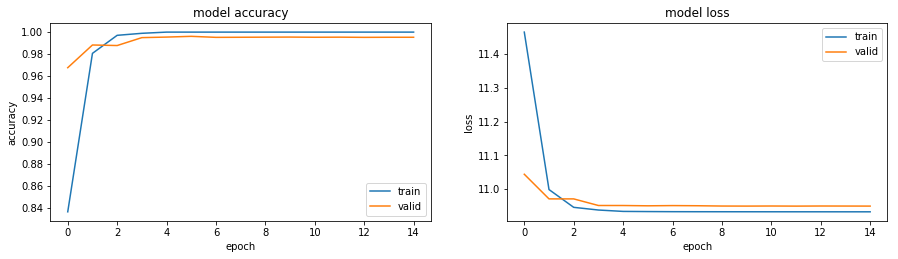

<Figure size 432x288 with 0 Axes>

In [12]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
         validation_data=validation_generator,
         validation_steps=STEPS_PER_EPOCH_VALIDATION,
         callbacks=[cb_checkpointer]
)

model.save(ROOT_PATH + 'my_model.h5')  # creates a HDF5 file 'my_model.h5'

with open(ROOT_PATH + '/train_history/' + FILE_NAME, 'wb') as file_pi:
        pickle.dump(fit_history.history, file_pi)
    
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()
plt.savefig(ROOT_PATH + TRAINING_FIG_FILE_NAME)

In [15]:
model.evaluate_generator(test_generator)


[10.962212211092586, 0.9935985]